In [1]:
import gzip
import warnings
import pickle
import os
from pathlib import Path
from chandra_aca import star_probs
from proseco import get_aca_catalog
from proseco.catalog import ACATable
from mica.starcheck import get_starcheck_catalog
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
matplotlib.style.use('bmh')
%matplotlib inline

In [2]:
mpdir = Path(os.environ['SKA']) / 'data' / 'mpcrit1' / 'mplogs'

In [3]:
def get_low_p2():
    outs = {}
    for path in sorted(mpdir.glob('202[23]/*/ofls/output/*_proseco.pkl.gz')):
        print(path)
        with gzip.open(path) as fh:
            acas_pkl: dict[int, ACATable] = pickle.load(fh)
            outs |= acas_pkl
            pass
    return outs

In [4]:
acas_pkl = get_low_p2()

/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR0122/ofls/output/APR0122A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR0322/ofls/output/APR0322A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR1122/ofls/output/APR1122A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR1822/ofls/output/APR1822A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR2522/ofls/output/APR2522A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG0122/ofls/output/AUG0122A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG0822/ofls/output/AUG0822A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG1322/ofls/output/AUG1322A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG2122/ofls/output/AUG2122A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG2222/ofls/output/AUG2222A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG2322/ofls/output/AUG2322A_proseco.pkl.gz
/Users/aldcroft/ska/d

In [5]:
len(acas_pkl)

2533

In [6]:
star_probs.DEFAULT_MODEL

'grid-floor-2020-02'

In [7]:
star_probs.DEFAULT_MODEL = 'grid-local-quadratic-2023-02'

In [8]:
p_floors_list = []
p_quads_list = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for aca in acas_pkl.values():
        t_ccd = aca.acqs.t_ccd
        acqs = aca.acqs
        p_floors = star_probs.acq_success_prob(
            t_ccd=t_ccd,
            mag=acqs["mag"],
            halfwidth=acqs["halfw"],
            model="grid-floor-2020-02",
        )
        p_quads = star_probs.acq_success_prob(
            t_ccd=t_ccd,
            mag=acqs["mag"],
            halfwidth=acqs["halfw"],
            model="grid-local-quadratic-2023-02",
        )
        p_floors_list.append(p_floors)
        p_quads_list.append(p_quads)

p_floors = np.concatenate(p_floors_list)
p_quads = np.concatenate(p_quads_list)
        

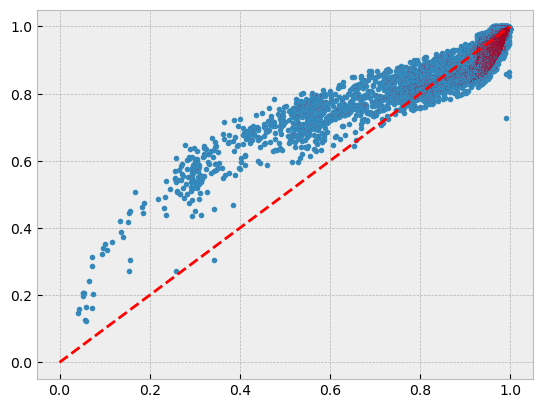

In [9]:
plt.plot(p_floors, p_quads, '.', color='C0')
plt.plot(p_floors, p_quads, ',', color='C1', alpha=0.2)
plt.plot([0, 1], [0, 1], 'r--');

In [10]:
def reselect_catalog(aca):
    kwargs = aca.call_args.copy()
    kwargs["include_ids_acq"] = list(aca.acqs['id'])
    kwargs["include_halfws_acq"] = list(aca.acqs['halfw'])
    kwargs["dark_date"] = aca.dark_date
    kwargs["n_acq"] = len(aca.acqs)

    star_probs.DEFAULT_MODEL = 'grid-floor-2020-02'
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        aca_orig = get_aca_catalog(**kwargs)
    p2_orig = -aca_orig.acqs.get_log_p_2_or_fewer()

    star_probs.DEFAULT_MODEL = 'grid-local-quadratic-2023-02'
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        aca_new = get_aca_catalog(**kwargs)
    p2_new = -aca_new.acqs.get_log_p_2_or_fewer()

    return p2_orig, p2_new

In [11]:
p2s_orig = []
p2s_new = []

for aca_pkl in acas_pkl.values():
    p2_pkl = -aca_pkl.acqs.get_log_p_2_or_fewer()
    if p2_pkl < 4.0:
        p2_orig, p2_new = reselect_catalog(aca_pkl)
        p2s_orig.append(p2_orig)
        p2s_new.append(p2_new)

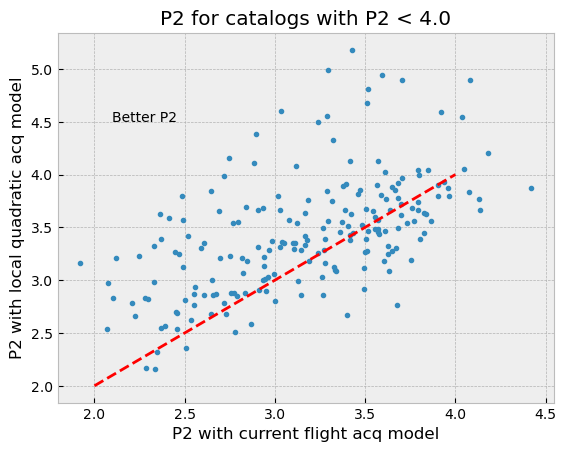

In [19]:
plt.plot(p2s_orig, p2s_new, '.', color='C0');
plt.plot([2, 4], [2, 4], 'r--');
plt.xlabel("P2 with current flight acq model")
plt.ylabel("P2 with local quadratic acq model")
plt.title("P2 for catalogs with P2 < 4.0");
plt.text(2.1, 4.5, "Better P2");

In [13]:
t_ccds, mags, halfwidths = np.meshgrid(np.arange(-12, -5.9, 1.0), np.arange(6, 10.76, 0.25), np.arange(60.0, 161, 20))

In [14]:
probs_quad = star_probs.acq_success_prob(mag=mags, t_ccd=t_ccds, halfwidth=halfwidths, model='grid-local-quadratic-2023-02').flatten()

In [15]:
probs_floor = star_probs.acq_success_prob(mag=mags, t_ccd=t_ccds, halfwidth=halfwidths, model='grid-floor-2020-02').flatten()

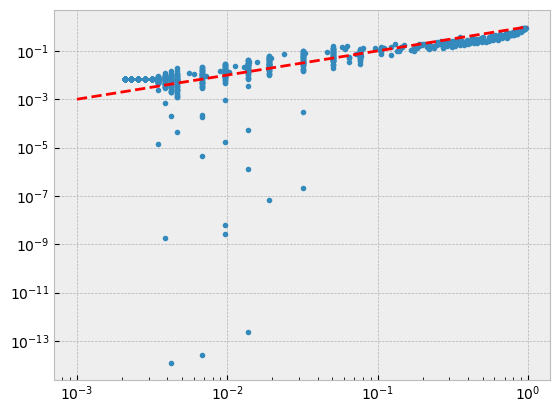

In [16]:
plt.loglog(1-probs_floor, 1-probs_quad, '.', color='C0');
plt.loglog([1e-3, 1], [1e-3, 1], 'r--');

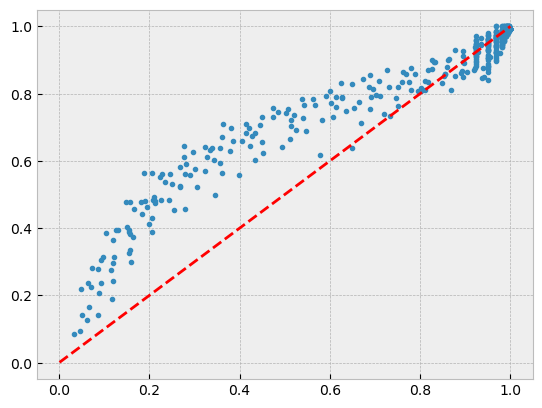

In [17]:
plt.plot(probs_floor, probs_quad, '.', color='C0');
plt.plot([1e-3, 1], [1e-3, 1], 'r--');

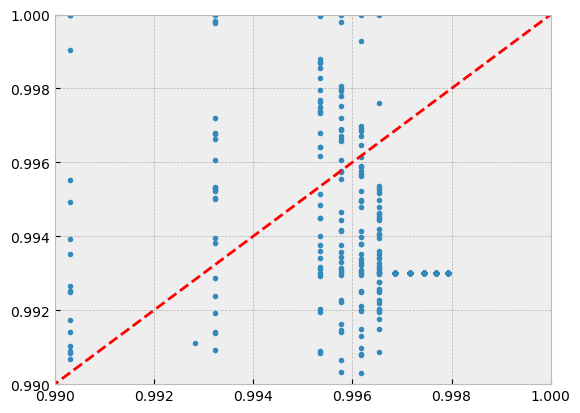

In [18]:
plt.plot(probs_floor, probs_quad, '.', color='C0');
plt.plot([1e-3, 1], [1e-3, 1], 'r--');
plt.xlim(0.99, 1)
plt.ylim(0.99, 1);